# Lesson 2

In the screencast for this lesson I go through a few scenarios for time series. This notebook contains the code for that with a few little extras! :)

# Setup

In [0]:
!pip install -U tf-nightly-2.0-preview

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [3]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

In [4]:
time = np.arange(4 * 365 + 1)

In [5]:
time[-10:]

array([1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460])

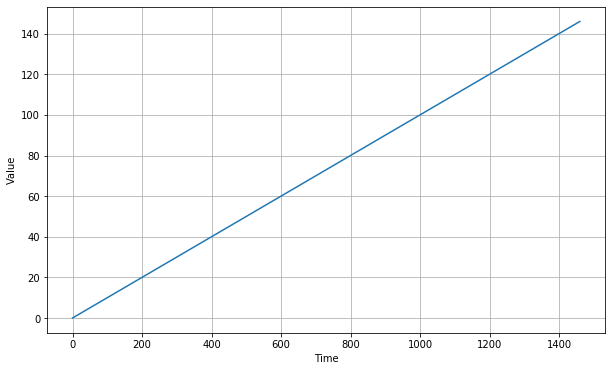

In [6]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [7]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

The time % period, like 2 % 365 we got 2, and 2/365 is our season_time, so the trend will repeat within each 365 days, and 365 * 0.4 is 146. So the seasonal pattern will change at this point.

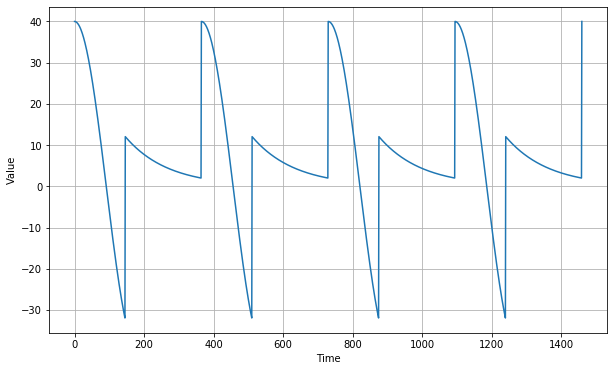

In [8]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

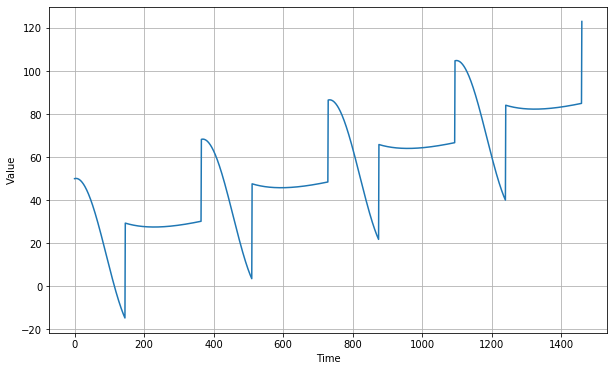

In [9]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [11]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

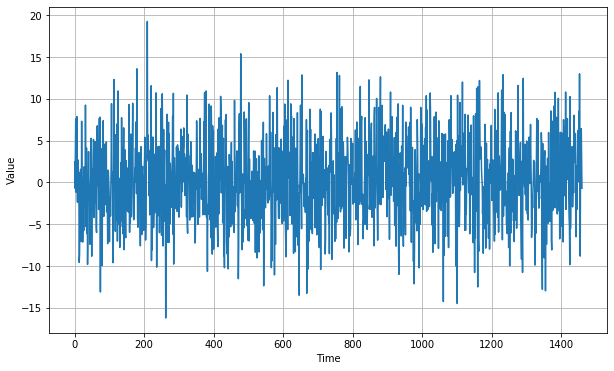

In [12]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

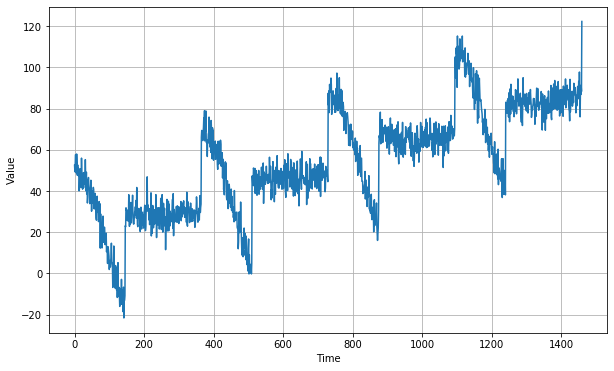

In [13]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [28]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [30]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

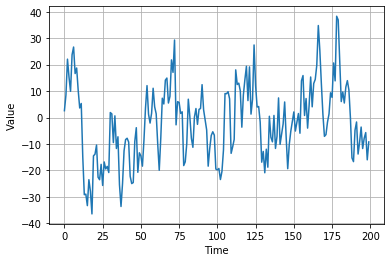

In [31]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

We can find out repeated pattern despite different scales.

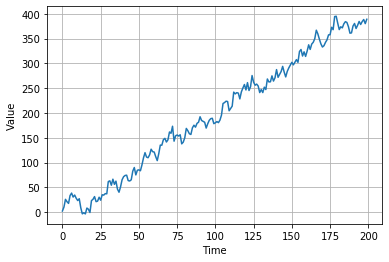

In [32]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

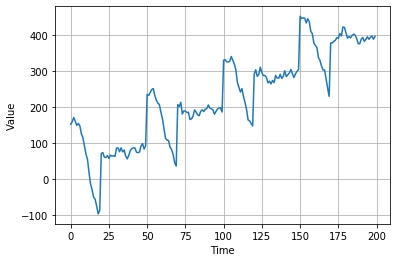

In [33]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

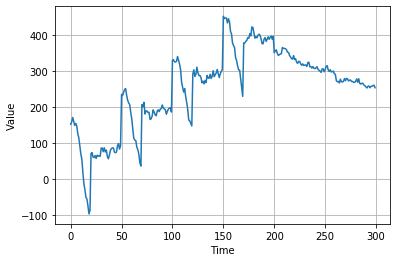

In [34]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
# series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()
# at first, it's shows seasonality. But at some point, things change

In [35]:
# plots some impulses
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

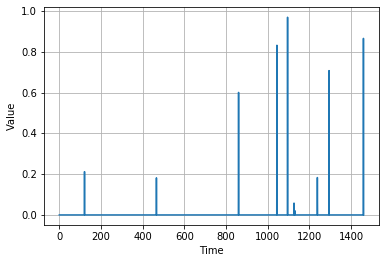

In [36]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [39]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

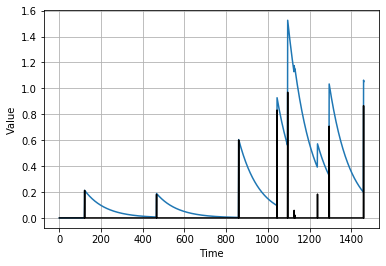

In [40]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

When I start adding some autocorrelations to this, then we'll see some of the behavior that we had discussed earlier where from our pulse we have a decay away from it but the decay could be interrupted by another pulse. This decay could be autocorrelated so that after the pulse it decays but then the decay autocorrelates. So we have these decreasing curves.

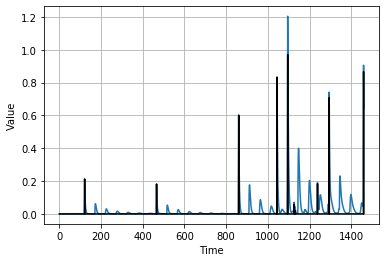

In [41]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

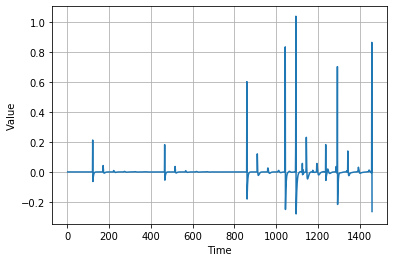

In [42]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

In [7]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

NameError: name 'series' is not defined

In [8]:
import pandas as pd

In [10]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                      ARIMA Model Results                                      
Dep. Variable:     D.Monthly Mean Total Sunspot Number   No. Observations:                 3234
Model:                                  ARIMA(5, 1, 0)   Log Likelihood              -15032.204
Method:                                        css-mle   S.D. of innovations             25.259
Date:                                 Fri, 29 Nov 2019   AIC                          30078.408
Time:                                         14:35:28   BIC                          30120.979
Sample:                                     02-28-1749   HQIC                         30093.662
                                          - 07-31-2018                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const       

In [9]:
df = pd.read_csv("/Users/hkmac/Desktop/Sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

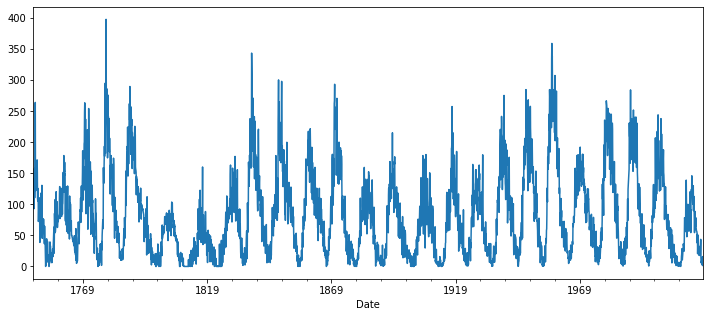

In [11]:
series.plot(figsize=(12, 5))

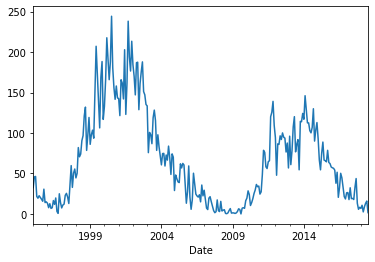

In [12]:
series["1995-01-01":].plot()

[0, 100, -50, 50]

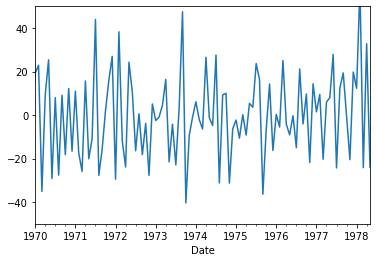

In [13]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

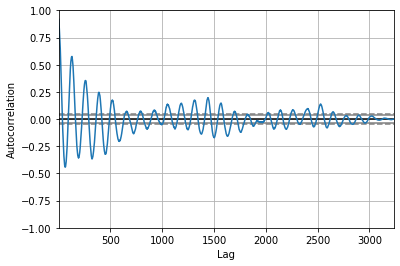

In [14]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

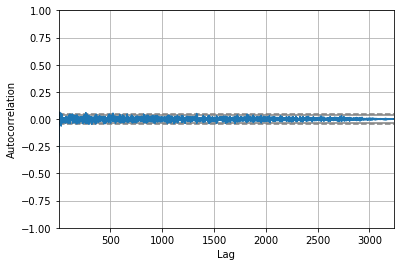

In [15]:
autocorrelation_plot(series.diff(1)[1:])

[0, 500, -0.1, 0.1]

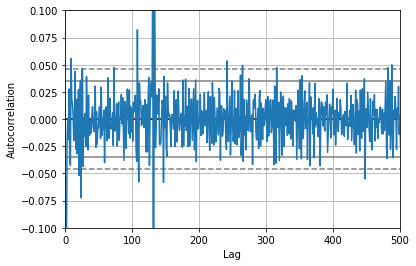

In [16]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

[0, 50, -0.1, 0.1]

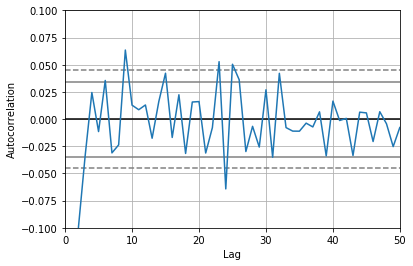

In [17]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [18]:
116.7 - 104.3

12.400000000000006

In [19]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367172,
 0.8847544206843757,
 0.8685991231372023,
 0.8579945644357172,
 0.8433856340533108,
 0.8306731729540906,
 0.8121138897370153,
 0.7986059878541054,
 0.7890399489112044,
 0.7689560950230402,
 0.7474788716472309,
 0.7238791854325143,
 0.6980482665379877,
 0.6751408790165825,
 0.6495670049994807,
 0.6170092179855492,
 0.5872028494447986,
 0.5537209387574676,
 0.5254318210710769,
 0.49453915657274106,
 0.4609225001523782,
 0.4325062022560218,
 0.40543298836102465,
 0.3695928959353228,
 0.34435498994607716,
 0.3106967622634348,
 0.2711411693399097,
 0.2364696401494821,
 0.20297806535027257,
 0.17379537689762672,
 0.14010793836897953,
 0.11227445177460693,
 0.07751076852866036,
 0.04405495796060674,
 0.012510863120931916,
 -0.017282156504566295,
 -0.04643335235751224,
 -0.07440203532677168,
 -0.10339501296715736,
 -0.12680806162977246,
 -0.15309282641975927,
 -0.17906178224521463,
 -0.20506772757843433,
 -0.22530867957591927,
 -0.24665870005795584,
 -0.2690460785496861,
 

In [21]:
pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
# Read a comma-separated values (csv) file into DataFrame.


NameError: name 'filepath_or_buffer' is not defined

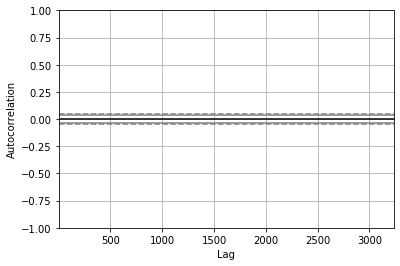

In [22]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
    series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

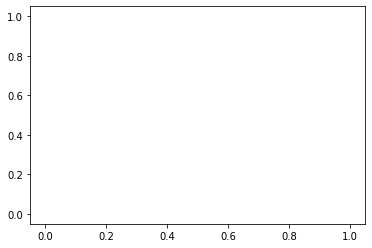

In [23]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()